# [ATM 623: Climate Modeling](../index.ipynb)
[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany
# Lecture 19: The surface energy balance

### About these notes:

This document uses the interactive [`IPython notebook`](http://ipython.org/notebook.html) format (now also called [`Jupyter`](https://jupyter.org)). The notes can be accessed in several different ways:

- The interactive notebooks are hosted on `github` at https://github.com/brian-rose/ClimateModeling_courseware
- The latest versions can be viewed as static web pages [rendered on nbviewer](http://nbviewer.ipython.org/github/brian-rose/ClimateModeling_courseware/blob/master/index.ipynb)
- A complete snapshot of the notes as of May 2015 (end of spring semester) are [available on Brian's website](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/index.html).

Many of these notes make use of the `climlab` package, available at https://github.com/brian-rose/climlab

## Contents

1. [Energy exchange mechanisms at the Earth's surface](#section1)
2. [Surface energy budget in CESM simulations](#section2)
3. [Sensible and Latent Heat Fluxes in the boundary layer](#section3)
4. [Bowen ratio in CESM simulations](#section4)


____________
<a id='section1'></a>

## 1. Energy exchange mechanisms at the Earth's surface
____________

The surface of the Earth is the boundary between the atmosphere and the land, ocean, or ice. Understanding the energy fluxes across the surface are very important for three main reasons:

1. We are most interested in the climate at the surface because we live at the surface.
2. The surface energy budget determines how much energy is available to evaporate water and moisten the atmosphere.
3. Air-sea energy fluxes set the thermal structure of the oceans, which in turn act to redistribute energy around the planet, with many important consequences for climate.

The energy budget at the surface is more complex that the budget at the top of the atmosphere. At the TOA the only energy transfer mechanisms are radiative (shortwave and longwave). At the surface, in addition to radiation we need to consider fluxes of energy by conduction and by convection of heat and moisture through turbulent fluid motion.

### Major terms in the surface energy budget

We will denote the **net upward energy flux at the surface** as $F_S$.

As we mentioned back in [Lecture 13 on heat transport](Lecture13 -- Heat transport.ipynb), there are four principal contributions to $F_S$:

1. Shortwave radiation
2. Longwave radiation
3. Sensible heat flux
4. Evaporation or latent heat flux

Wherever $F_S \ne 0$, there is a net flux of energy between the atmosphere and the surface below. This implies either that there is heat storage / release occuring below the surface (e.g. warming or cooling of water, melting of snow and ice), and/or there is horizontal heat transport by fluid motions occuring below the surface (ocean circulation, groundwater flow).

### Minor terms in the surface energy budget

All of these terms are small globally but can be significant locally or seasonally.

- Latent heat of fusion required for melting ice and snow
- Conversion of the kinetic energy of winds and waves to thermal energy
- Heat transport by precipitation, if precipitation is at a different temperature than the surface
- Biological uptake of solar energy through photosynthesis
- Biological release of energy through oxidation (respiration, decay, fires)
- Geothermal heat sources (hot springs, volcanoes, etc.)
- Anthropogenic heat released through fossil fuel burning and nuclear power generation.

____________
<a id='section2'></a>

## 2. The surface energy budget in CESM simulations
____________

We will examine the surface budget in the CESM slab ocean simulations. The advantage of looking at surface fluxes in a model rather than observations is that the model fluxes are completely consistent with the model climate, so that the net flux $F_S$ will be a meaningful measure of the heat storage in the system.

The model also gives us an opportunity to look at how the surface budget reponds to global warming under a doubling of CO$_2$.

### First, load the data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from climlab import constants as const

In [2]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/"
endstr = "/entry.das"
topo = nc.Dataset( datapath + 'som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc' + endstr )

runlist = ['control', '2xCO2']
runs = {}
for run in runlist:
    runstr = 'som_' + run
    path = datapath + runstr + '/' + runstr + '.cam.h0.clim.nc' + endstr
    runs[run] = nc.Dataset( path )

In [3]:
lat = runs['control'].variables['lat'][:]
lon = runs['control'].variables['lon'][:]
lev = runs['control'].variables['lev'][:]

### Annual mean surface energy budget

In [4]:
#  annual mean surface energy budget terms, all defined as positive up (from ocean to atmosphere)
surface_budget = {}

for name, run in runs.iteritems():
    budget = {}
    budget['LHF'] = np.mean(run.variables['LHFLX'][:], axis=0)
    budget['SHF'] = np.mean(run.variables['SHFLX'][:], axis=0)
    budget['LWsfc'] = np.mean(run.variables['FLNS'][:], axis=0)
    budget['LWsfc_clr'] = np.mean(run.variables['FLNSC'][:], axis=0)
    budget['SWsfc'] = -np.mean(run.variables['FSNS'][:], axis=0)
    budget['SWsfc_clr'] = -np.mean(run.variables['FSNSC'][:], axis=0)
    budget['SnowFlux'] =  (np.mean(run.variables['PRECSC'][:]+run.variables['PRECSL'][:], axis=0)
                       *const.rho_w*const.Lhfus)
    budget['NetRad'] = budget['LWsfc'] + budget['SWsfc']  # net upward radiation from surface
    # net upward surface heat flux
    budget['Net'] = (budget['NetRad'] + budget['LHF'] + 
                             budget['SHF'] + budget['SnowFlux'])
    budget['LWsfc_cld'] = budget['LWsfc'] - budget['LWsfc_clr']  # all the surface radiation terms are defined positive up
    budget['SWsfc_cld'] = budget['SWsfc'] - budget['SWsfc_clr']
    budget['NetRad_clr'] = budget['LWsfc_clr'] + budget['SWsfc_clr']  
    budget['NetRad_cld'] = budget['NetRad'] - budget['NetRad_clr']

    surface_budget[name] = budget

In [5]:
#  Compute anomalies for all terms
anom = {}
for name in surface_budget['control']:
    anom[name] = surface_budget['2xCO2'][name] - surface_budget['control'][name]
surface_budget['anom'] = anom

In [6]:
#  Also compute zonal averages
zonal_budget = {}
for run, budget in surface_budget.iteritems():
    thiszon = {}
    for field in budget:
        thiszon[field] = np.mean(budget[field], axis=1)
    zonal_budget[run] = thiszon

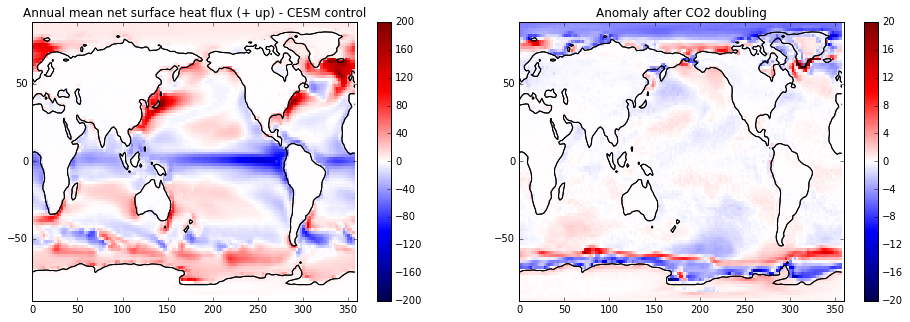

In [7]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1, 2, 1)
cax1 = ax1.pcolormesh(lon, lat, surface_budget['control']['Net'],
                    cmap=plt.cm.seismic, vmin=-200., vmax=200. )
fig.colorbar(cax1)
ax1.set_title('Annual mean net surface heat flux (+ up) - CESM control')

ax2 = fig.add_subplot(1, 2, 2)
cax2 = ax2.pcolormesh(lon, lat, surface_budget['anom']['Net'],
                    cmap=plt.cm.seismic, vmin=-20., vmax=20. )
fig.colorbar(cax2)
ax2.set_title('Anomaly after CO2 doubling')

for ax in [ax1, ax2]:
    ax.set_xlim(0, 360)
    ax.set_ylim(-90, 90)
    ax.contour( lon, lat, topo.variables['LANDFRAC'][:], [0.5,0.5], colors='k');

These figures show the annual mean net upward flux $F_S$ in the control run, and the anomaly after greenhouse warming.

Some notable points about the control state:

- The net flux over all land surfaces is very close to zero!
- In the long-term annual mean, a non-zero $F_S$ must be balanced by heat transport. 
- The spatial pattern of $F_S$ over the oceans is essentially just the prescribed q-flux that we have imposed on the slab ocean to represent ocean heat transport.
- We have looked at maps like this before, back in [Lecture 13](Lecture13 -- Heat transport.ipynb) and [Assignment 3](../Assignments/Assignment03 -- Introducing CESM.ipynb).
- Net heat uptake by the oceans occurs mostly along the equator and the cold tongues on the eastern sides of the tropical basins.
- Net heat release from oceans to atmosphere occurs mostly in mid- to high latitudes. Hot spots include the Gulf Stream and Kuroshio regions on the western sides of the mid-latitude basins, as well as the subpolar North Atlantic. These features are largely determined by ocean dynamics.

**After greenhouse warming**:

- The net change in $F_S$ is very small in most locations. 
- This indicates that the model has reached quasi-equilibrium. Non-zero changes in $F_S$ would indicate either
    - heat storage below the surface
    - changes in ocean heat transport (not permitted in a slab ocean model).
- Non-zero changes are found in areas where the sea ice cover is changing in the model.

### Variation of energy balance components with latitude

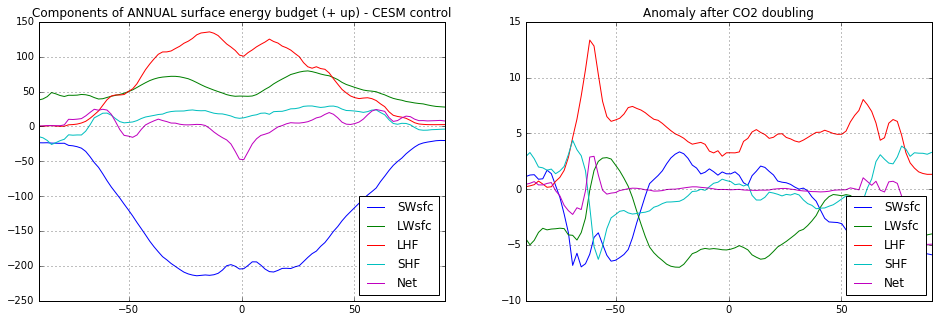

In [8]:
fieldlist = ['SWsfc', 'LWsfc', 'LHF', 'SHF', 'Net']

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1, 2, 1)
for field in fieldlist:
    ax1.plot(lat, zonal_budget['control'][field], label=field)
ax1.set_title('Components of ANNUAL surface energy budget (+ up) - CESM control')

ax2 = fig.add_subplot(1, 2, 2)
for field in fieldlist:
    ax2.plot(lat, zonal_budget['anom'][field], label=field)
ax2.set_title('Anomaly after CO2 doubling')

for ax in [ax1, ax2]:
    ax.set_xlim(-90, 90)
    ax.grid()
    ax.legend(loc='lower right')

In these graphs, the magenta curve labeled "Net" is the net flux $F_S$. It is just the zonal average of the maps from the previous figure, and shows the ocean heat uptake at the equator and release in mid- to high latitudes.

More interestingly, these graphs show the contribution of the various terms to $F_S$. They are all plotted as positive up. A **negative** value thus indicates **heating of the surface**, and a **positive** value indicates a **cooling of the surface**.

Key points about the control simulation:

- Solar radiation acts to warm the surface everywhere. 
- Note that this is a net shortwave flux, so it is the amount that is actually absorbed by the surface after accounting for the reflected fraction.
- All other mechanisms act to cool the surface. 
- The dominant balance across the **tropics** is between **warming by solar radiation** and **cooling by evaporation** (latent heat flux or LHF).
- The latent heat flux decreases poleward.
- Latent heat flux is dominant over sensible heat flux at most latitudes except close to the poles.
- The net longwave radiation also acts to cool the surface.
- This is the residual between the surface emissions (essentially $\sigma~T_s^4$) and the back-radiation from the atmosphere.

** After greenhouse warming **

- The anomaly in net upward longwave radiation is negative at most latitudes.
- This implies that the downwelling back-radiation increases faster than the upwelling surface emissions.
- This is a signature of greenhouse warming! Both the upwelling and downwelling beams increase with warming. But the downwelling beam also increases because of the CO$_2$-induced increase in emissivity of the atmosphere.
- So the surface is warmed by excess longwave radiation.
- This warming is largely balanced by increased evaporation (red curve)!
- There are also significant changes in shortwave radiation. We could use the modeled clear-sky diagnostics to infer which of these changes are due to clouds.
- The negative shortwave anomalies in high latitudes are consistent with surface albedo feedback and loss of ice and snow.

###  Seasonal variations

We will compute the budgets for the months of January and July, and plot their differences.

In [9]:
jan_budget = {}

for name, run in runs.iteritems():
    budget = {}
    budget['LHF'] = run.variables['LHFLX'][0,:,:]
    budget['SHF'] = run.variables['SHFLX'][0,:,:]
    budget['LWsfc'] = run.variables['FLNS'][0,:,:]
    budget['LWsfc_clr'] = run.variables['FLNSC'][0,:,:]
    budget['SWsfc'] = -run.variables['FSNS'][0,:,:]
    budget['SWsfc_clr'] = -run.variables['FSNSC'][0,:,:]
    budget['SnowFlux'] =  ((run.variables['PRECSC'][0,:,:]+run.variables['PRECSL'][0,:,:])
                       *const.rho_w*const.Lhfus)
    budget['NetRad'] = budget['LWsfc'] + budget['SWsfc']  # net upward radiation from surface
    # net upward surface heat flux
    budget['Net'] = (budget['NetRad'] + budget['LHF'] + 
                             budget['SHF'] + budget['SnowFlux'])
    budget['LWsfc_cld'] = budget['LWsfc'] - budget['LWsfc_clr']  # all the surface radiation terms are defined positive up
    budget['SWsfc_cld'] = budget['SWsfc'] - budget['SWsfc_clr']
    budget['NetRad_clr'] = budget['LWsfc_clr'] + budget['SWsfc_clr']  
    budget['NetRad_cld'] = budget['NetRad'] - budget['NetRad_clr']

    jan_budget[name] = budget

In [10]:
jul_budget = {}

for name, run in runs.iteritems():
    budget = {}
    budget['LHF'] = run.variables['LHFLX'][6,:,:]
    budget['SHF'] = run.variables['SHFLX'][6,:,:]
    budget['LWsfc'] = run.variables['FLNS'][6,:,:]
    budget['LWsfc_clr'] = run.variables['FLNSC'][6,:,:]
    budget['SWsfc'] = -run.variables['FSNS'][6,:,:]
    budget['SWsfc_clr'] = -run.variables['FSNSC'][6,:,:]
    budget['SnowFlux'] =  ((run.variables['PRECSC'][6,:,:]+run.variables['PRECSL'][6,:,:])
                       *const.rho_w*const.Lhfus)
    budget['NetRad'] = budget['LWsfc'] + budget['SWsfc']  # net upward radiation from surface
    # net upward surface heat flux
    budget['Net'] = (budget['NetRad'] + budget['LHF'] + 
                             budget['SHF'] + budget['SnowFlux'])
    budget['LWsfc_cld'] = budget['LWsfc'] - budget['LWsfc_clr']  # all the surface radiation terms are defined positive up
    budget['SWsfc_cld'] = budget['SWsfc'] - budget['SWsfc_clr']
    budget['NetRad_clr'] = budget['LWsfc_clr'] + budget['SWsfc_clr']  
    budget['NetRad_cld'] = budget['NetRad'] - budget['NetRad_clr']

    jul_budget[name] = budget

In [11]:
#  July minus January
julminusjan_budget = {}
for run in runs:
    anom = {}
    for name in jan_budget[run]:
        anom[name] = jul_budget[run][name] - jan_budget[run][name]
    julminusjan_budget[run] = anom

In [12]:
#  Compute anomalies for all terms
anom = {}
for name in julminusjan_budget['control']:
    anom[name] = julminusjan_budget['2xCO2'][name] - julminusjan_budget['control'][name]
julminusjan_budget['anom'] = anom

In [13]:
#  Also compute zonal averages
julminusjan_zonal_budget = {}
for run, budget in julminusjan_budget.iteritems():
    thiszon = {}
    for field in budget:
        thiszon[field] = np.mean(budget[field], axis=1)
    julminusjan_zonal_budget[run] = thiszon

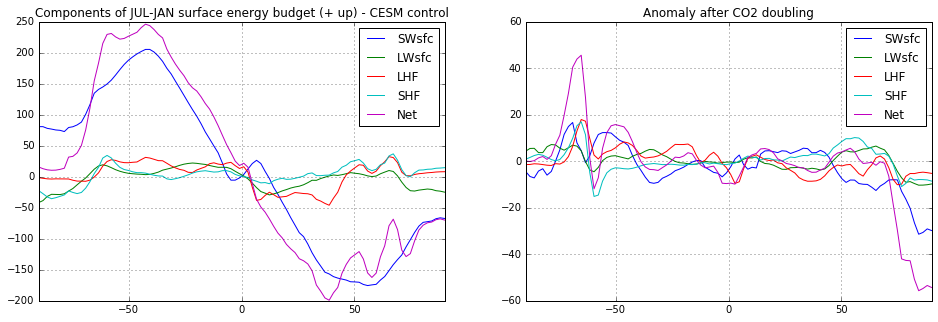

In [14]:
fieldlist = ['SWsfc', 'LWsfc', 'LHF', 'SHF', 'Net']

fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(1, 2, 1)
for field in fieldlist:
    ax1.plot(lat, julminusjan_zonal_budget['control'][field], label=field)
ax1.set_title('Components of JUL-JAN surface energy budget (+ up) - CESM control')

ax2 = fig.add_subplot(1, 2, 2)
for field in fieldlist:
    ax2.plot(lat, julminusjan_zonal_budget['anom'][field], label=field)
ax2.set_title('Anomaly after CO2 doubling')

for ax in [ax1, ax2]:
    ax.set_xlim(-90, 90)
    ax.grid()
    ax.legend()

Seasonally, the dominant balance by far is between solar radiation and heat storage!

____________
<a id='section3'></a>

## 3. Sensible and Latent Heat Fluxes in the boundary layer
____________

These notes largely follow Chapter 4 of Hartmann (1994) "Global Physical Climatology", Academic Press.

Turbulent fluxes of heat: eddy fluxes of heat and moisture at some level in the atmospheric boundary layer

$$ \text{SH} = c_p ~\rho ~ \overline{w^\prime T^\prime} $$

$$ \text{LE} = L ~\rho ~\overline{w^\prime q^\prime} $$

where $c_p$ is the specific heat of air at constant pressure, $L$ is the latent heat of vaporization, $\text{SH}$ is the sensible heat flux and $\text{LE}$ is the latent heat flux.

### Bulk aerodynamic formulas

From theory of boundary layer turbulence, we suppose that the eddy heat fluxes is related to boundary layer temperature gradients, as well as the mean wind speed:

$$ \text{SH} = c_p ~\rho ~ C_D ~ U \left( T_s - T_a \right) $$

where $T_s$ is the surface temperature and $T_a$ is the air temperature at some reference height above the surface. $U$ is the wind speed at the reference height, and $C_D$ is a dimensionless aerodynamic drag coefficient.

$C_D$ will depend, among other things, on the roughness of the surface.

Similarly, we assume that the latent heat flux is related to boundary layer moisture gradients:

$$ \text{LE} = L ~\rho ~ C_D ~ U \left( q_s - q_a \right) $$

where $q_s$ is the specific humidity of air immediately above the surface, and $q_a$ is the specific humidity at the reference height.

In general the transfer coefficients $C_D$ could be different for sensible and latent heat flux, but empirically they are found to be very similar to each other. We will assume they are equal here.

### The Bowen ratio

The **Bowen ratio** is a dimensionless number defined as 

$$  B_o = \frac{\text{SH}}{\text{LE}} $$

i.e. the ratio of **sensible heat loss** to **evaporative cooling**.

From the above plots, the Bowen ratio tends to be small in the low latitudes.

### The Bowen ratio for wet surfaces

Over a water surface or a very wet land surface, we may assume that the mixing ratio of water vapor at the surface is equal to the saturation mixing ratio $q^*$ at the temperature of the surface:

$$ q_s = q^*(T_s) $$

Recall that the saturation vapor pressure $q^*$ is a sensitive function of temperature through the Clausius-Claperyon relation. (It also depends on pressure)

Let's approximate the mixing ratio for **saturated air** at the reference height through a first-order Taylor series expansion:

$$ q_a^* \approx q_s^*(T_s) + \frac{\partial q^*}{\partial T} \left( T_a - T_s \right) $$

The actual mixing ratio at the reference height can be expressed as

$$ q_a = r ~ q_a^* $$

where $r$ is the relative humidity at that level.

Then we have an appoximation for $q_a$ in terms of temperature gradients:

$$ q_a \approx r \left( q_s^*(T_s) + \frac{\partial q^*}{\partial T} \left( T_a - T_s \right) \right) $$

Substituting this into the bulk formula for latent heat flux, we get

$$ \text{LE} \approx L ~\rho ~ C_D ~ U \left( q_s^* - r \left( q_s^* + \frac{\partial q^*}{\partial T} \left( T_a - T_s \right) \right) \right) $$

or, rearranging a bit,

$$ \text{LE} \approx L ~\rho ~ C_D ~ U \left( (1-r) ~ q_s^* + r \frac{\partial q^*}{\partial T} \left( T_s - T_a \right) \right)  $$

The Bowen ratio is thus

$$ B_o = \frac{c_p}{ L \left( \frac{(1-r)}{\left( T_s - T_a \right)} q_s^* + r \frac{\partial q^*}{\partial T} \right)} $$



### The equilibrium Bowen ratio (for saturated air)

Notice that **if the boundary layer air is saturated**, then $r=1$ and the Bowen ratio takes on a special value

$$ B_e = \frac{c_p}{ L \frac{\partial q^*}{\partial T} } $$

When the surface and the air at the reference level are saturated, the Bowen ratio approaches the value $B_e$, which is called the equilibrium Bowen ratio. We presume that the flux of moisture from the boundary layer to the free atmosphere is sufficient to just balance the upward flux of moisture from the surface so that the humidity at the reference height is in equilibrium at the saturation value.


Recall that from the Clausius-Claperyon relation, the rate of change of the saturation mixing ratio is itself a strong function of temperature:

$$ \frac{\partial q^*}{\partial T} = q^*(T) \frac{L}{R_v ~ T^2} $$

Here the quasi-exponential dependence of $q^*$ on $T$ far outweighs the inverse square dependence, so the equilibrium Bowen ratio decreases roughly exponentially with temperature.

The following code reproduces Figure 4.10 of Hartmann (1994). 

In [15]:
from climlab.utils.thermo import qsat
T = np.linspace(-40, 40) + const.tempCtoK
qstar = qsat(T, const.ps)  # in kg / kg

def Be(T):
    qstar = qsat(T, const.ps)  # in kg / kg
    dqstardT = qstar * const.Lhvap / const.Rv / T**2
    return const.cp / const.Lhvap / dqstardT

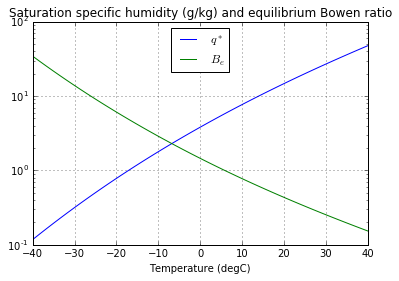

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(T + const.tempKtoC, qstar*1000, label='$q^*$')
ax.semilogy(T + const.tempKtoC, Be(T), label='$B_e$')
ax.grid()
ax.set_xlabel('Temperature (degC)')
ax.legend(loc='upper center')
ax.set_title('Saturation specific humidity (g/kg) and equilibrium Bowen ratio')

- Equilibrium Bowen ratio is near 1 at 0ºC, and decreases to about 0.2 at 30ºC.
- As relative humidity is decreased from 1 to smaller values, **evaporative cooling increases**.
- The equilibrium Bowen ratio is the **maximum possible Bowen ratio for a wet surface**.
- Actual Bowen ratio over a wet surface will generally be smaller than $B_e$, because the air is usually not saturated.
- Because of the strong temperature dependence of the saturation specific humidity:
    - Evaporative cooling (latent heat flux) dominates over sensible cooling of wet surfaces at **tropical** temperatures.
    - Sensible heat flux becomes important wherever the surface is either **cold** or **dry**.

____________
<a id='section4'></a>

## 4. Bowen ratio in CESM simulations
____________

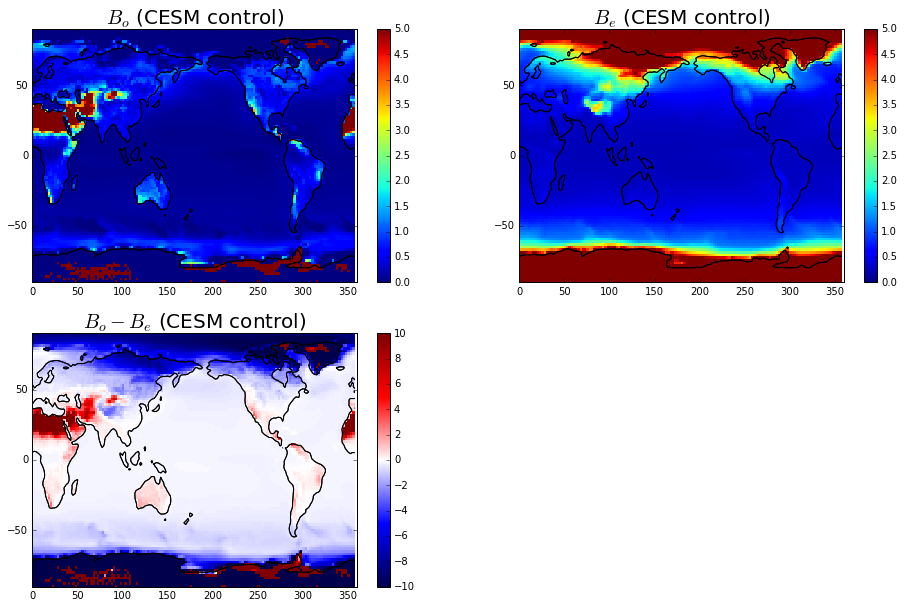

In [17]:
Bo_control = surface_budget['control']['SHF']/surface_budget['control']['LHF']
Be_control = np.mean(Be(runs['control'].variables['TS'][:]), axis=0)

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2, 2, 1)
cax1 = ax1.pcolormesh(lon, lat, Bo_control,
                    vmin=0., vmax=5. )
fig.colorbar(cax1)
ax1.set_title('$B_o$ (CESM control)', fontsize=20)

ax2 = fig.add_subplot(2, 2, 2)
cax2 = ax2.pcolormesh(lon, lat, Be_control,
                    vmin=0., vmax=5. )
fig.colorbar(cax2)
ax2.set_title('$B_e$ (CESM control)', fontsize=20)

ax3 = fig.add_subplot(2, 2, 3)
cax3 = ax3.pcolormesh(lon, lat, Bo_control - Be_control,
                    cmap='seismic', vmin=-10., vmax=10. )
fig.colorbar(cax3)
ax3.set_title('$B_o - B_e$ (CESM control)', fontsize=20)

for ax in [ax1, ax2, ax3]:
    ax.set_xlim(0, 360)
    ax.set_ylim(-90, 90)
    ax.contour( lon, lat, topo.variables['LANDFRAC'][:], [0.5,0.5], colors='k');

On the difference plot, the blue colors indicate the actual Bowen ratio is smaller than the equilibrium Bowen ratio. This will typically occur for **wet surfaces** with **undersaturated air**.

The red colors indicate the actual Bowen ratio is larger than the equilibrium Bowen ratio. This typically occurs for **dry surfaces** where there is not enough water available to satisfy the energetic demand for evaporation.

<div class="alert alert-success">
[Back to ATM 623 notebook home](../index.ipynb)
</div>

____________
## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php), offered in Spring 2015.
____________

____________
## Version information
____________


In [18]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py
%load_ext version_information
%version_information numpy, climlab

Installed version_information.py. To use it, type:
  %load_ext version_information


/Users/Brian/anaconda/lib/python2.7/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension(s)as a python packages.
  "as a python packages.", UserWarning)


Software versions
Python 2.7.10 64bit [GCC 4.2.1 (Apple Inc. build 5577)]
IPython 4.0.0
OS Darwin 15.0.0 x86_64 i386 64bit
numpy 1.10.1
climlab 0.2.11
Sun Nov 29 15:33:57 2015 EST